# Transformer

2017年にGoogleによって発表されたEncoder-Decoderモデル (seq2seq) 。  
"Attention is All You Need"という論文タイトルは有名。

論文のタイトル通り、Attentionを軸としたモデルで、RNNも用いていない。  
Transformerはその性能の高さから至る所で活躍しており、現在世に存在する高度な言語モデルのほぼ全てがTransformerを元に作られていると言っても過言ではない。

本章ではtransformerの理解と実装を行う。  
まず、encoderに使われる機構を学び、それらを組み合わせてencoderを実装する。その後にencoderを少しいじることで作れるdecoderを実装し、最後にその二つを組み合わせてtransformerを実装する。

In [1]:
import random

import matplotlib.pyplot as plt
import sentencepiece as spm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from dlprog import train_progress

In [2]:
prog = train_progress(with_test=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 学習データの用意

In [3]:
textfile_ja = 'data/iwslt2017_ja_10000.txt'
textfile_en = 'data/iwslt2017_en_10000.txt'
tokenizer_prefix_ja = f'models/tokenizer_iwslt2017_ja_10000'
tokenizer_prefix_en = f'models/tokenizer_iwslt2017_en_10000'

with open(textfile_en) as f:
    data_en = f.read().splitlines()

with open(textfile_ja) as f:
    data_ja = f.read().splitlines()

n_data = len(data_en)
print('num of data:', n_data)

sp_ja = spm.SentencePieceProcessor(f'{tokenizer_prefix_ja}.model')
sp_en = spm.SentencePieceProcessor(f'{tokenizer_prefix_en}.model')
unk_id = sp_ja.unk_id()
bos_id = sp_ja.bos_id()
eos_id = sp_ja.eos_id()
pad_id = sp_ja.pad_id()
n_vocab_ja = len(sp_ja)
n_vocab_en = len(sp_en)
print('num of vocabrary (ja):', n_vocab_ja)
print('num of vocabrary (en):', n_vocab_en)

num of data: 10000
num of vocabrary (ja): 8000
num of vocabrary (en): 8000


In [4]:
data_ids_ja = sp_ja.encode(data_ja)
data_ids_en = sp_en.encode(data_en)

for ids_ja, ids_en in zip(data_ids_ja, data_ids_en):
    ids_ja.append(eos_id)
    ids_en.insert(0, bos_id)
    ids_en.append(eos_id)

In [5]:
class TextDataset(Dataset):
    def __init__(self, data_ids_ja, data_ids_en):
        self.data_ja = [torch.tensor(ids) for ids in data_ids_ja]
        self.data_en = [torch.tensor(ids) for ids in data_ids_en]
        self.n_data = len(self.data_ja)

    def __getitem__(self, idx):
        ja = self.data_ja[idx]
        en = self.data_en[idx]
        x_enc = ja
        x_dec = en[:-1]
        y_dec = en[1:]
        return x_enc, x_dec, y_dec

    def __len__(self):
        return self.n_data

def collate_fn(batch):
    x_enc, x_dec, y_dec= zip(*batch)
    x_enc = pad_sequence(x_enc, batch_first=True, padding_value=pad_id)
    x_dec = pad_sequence(x_dec, batch_first=True, padding_value=pad_id)
    y_dec = pad_sequence(y_dec, batch_first=True, padding_value=pad_id)
    return x_enc, x_dec, y_dec

dataset = TextDataset(data_ids_ja, data_ids_en)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    drop_last=True,
    collate_fn=collate_fn
)


---

## Positional Encoding

位置エンコーディング。位置符号をデータに足す。データに位置情報を埋め込む。

現状、encoder内に存在するRNNの役割は「位置情報を含んだ隠れ状態を出力すること」にある。

通常のseq2seqでは、decoderが参照する「最後の隠れ状態」に全ての文脈の情報が乗る様に、時間ごとの演算が繋がっている必要があった。  
しかし、attentionによって全ての隠れ状態を参照できる様になった今、最後の隠れ状態に全ての情報が乗っている必要はなくなった。

このとき、時間ごとの演算が繋がっている必要もない様に思える。適当なFFNで、独立して各時間の隠れ状態を出力すれば良いのではないかと。  
ただ問題があり、それは入力文の語順が考慮されなくなってしまうことである。attentionは重み付き話を取るだけなので、順番を考慮する能力はない。重み付き和は順番に依らない。例を用いると、「私は猫が好きです」と「猫は私が好きです」がdecoderにとって同じ意味になってしまうということだ。  
RNNはそれを回避するためにある、となる。

逆に言えば、それさえ解消できればencoderの中にRNNは要らなくなるということだ。各時間で出力される隠れ状態になんらかの形で位置情報を埋め込めば良い。  
RNNは再帰性を持つため、並列化ができず、学習に時間がかかるというデメリットがある。RNNを消すメリットはそこに存在する。

位置情報の埋め込みは位置符号を足すことで実現される。位置符号は、位置ごとに一意に定められたベクトル。  
位置符号を用意することが位置エンコーディングにあたる。

例えば$(1, 1, \cdots, 1), (2, 2, \cdots, 2), \cdots, (l, l, \cdots, l)$というベクトルは位置符号である。

$$
PE_{(pos, i)} = pos
$$

- $pos$: 位置
- $i$: 次元

例として、5次元のデータに対する位置符号を考える。

In [6]:
d = 5 # 次元
length = 4 # 長さ
ps = torch.arange(length).unsqueeze(1).broadcast_to(length, d) # 位置エンコーディング
ps # 位置符号

tensor([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3]])

これをデータに足す。

In [7]:
x = torch.randn(length, d) # データ
x = x + ps[:length] # 位置埋め込み
x

tensor([[-0.1664,  0.9125, -1.0518, -0.2935, -0.5158],
        [ 0.2564,  2.6195,  2.4767,  2.1123,  0.3464],
        [ 1.8312,  1.0220,  1.3699,  2.8427,  1.2735],
        [ 3.1249,  3.9024,  2.5908,  3.4378,  1.2159]])

これで、位置情報がデータに足された、となる。  
位置符号はヒートマップでよく表す。

In [8]:
def heatmap(ps):
    plt.figure(figsize=(10, 3))
    plt.imshow(ps.numpy(), cmap='gray')
    plt.colorbar()
    plt.title('Positional Encoding')
    plt.xlabel('dim')
    plt.ylabel('pos')
    plt.xticks([])
    plt.yticks([]);

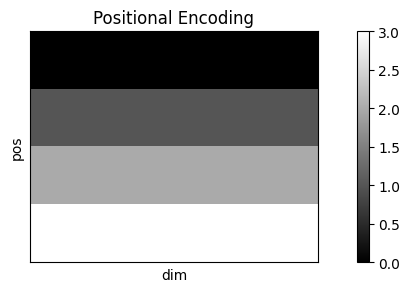

In [9]:
heatmap(ps)

### Transformerへの導入

transformerでは、三角関数を用いた位置符号を用いる。

$$
PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}}) \\
PE_{(pos, 2i + 1)} = \cos(pos / 10000^{2i / d_{model}})
$$

- $d_{model}$: 隠れ状態の次元数

次元が奇数か偶数かで$\sin$と$\cos$が変わる。

この式である理由はなんだろうね。  
googleさんが色々試して一番良かったやつ、と私は認識していて、それ以上を考える気は起きないので、おわり。

層として実装してみよう。長さを入れるとそこまでの位置符号が返ってくる層。

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        pe = self._get_pe()
        self.register_buffer('pe', pe)

    def forward(self, length: int):
        pe = self.pe[:length]
        return pe

    def _get_pe(self):
        pos = torch.arange(0, self.max_len).unsqueeze(1)
        div = 10000 ** (torch.arange(0, self.d_model, 2) / self.d_model)
        pe = torch.zeros(self.max_len, self.d_model)
        pe[:, 0::2] = torch.sin(pos / div)
        pe[:, 1::2] = torch.cos(pos / div)
        return pe

`_get_pe()`が数式の部分。位置符号をモデル（`nn.Module`）に紐づけるために`register_buffer()`を使う。

ヒートマップはこう。

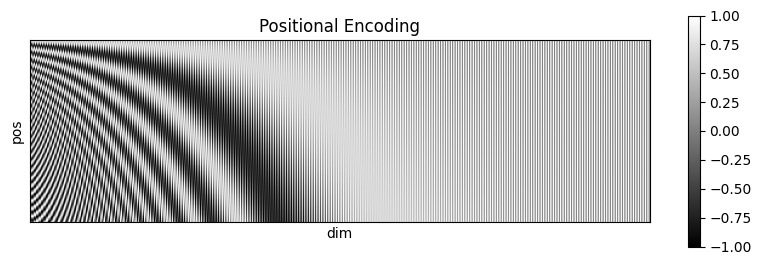

In [11]:
d_model = 512
length = 150
pe = PositionalEncoding(d_model)
ps = pe(length)
heatmap(ps)

位置符号を学習させるという手段もある。後にTransformerの発展系として発表されたBERTやGPTなどではそうされている。  


---

## Self-Attention

入力とmemoryが同じattention。

複数のデータがあり、その中の一つが入力、それ以外のデータがmemoryとなる。それ以外と書いたが、実際は入力もmemoryに含まれる。  
「あるデータとそれ以外のデータのattention」を全てのデータで求め、各データに対応した新たなデータを得る。

やってみよう。適当なデータを用意する。

In [12]:
n = 3
d = 5
x = torch.randn(n, d)
x

tensor([[-0.0879,  1.4295, -0.5967, -0.3655,  0.5459],
        [ 1.2615,  1.2643,  0.1394, -0.0372, -0.5065],
        [-1.7865, -0.7370, -0.6705, -0.2303,  0.1054]])

全てのデータでattentionを求める

In [13]:
def attention(x, memory):
    scores = x @ memory.T
    weights = F.softmax(scores, dim=-1)
    y = weights @ memory
    return y

y = []
for xi in x:
    yi = attention(xi, x)
    y.append(yi)
y = torch.stack(y)
y

tensor([[ 0.0976,  1.3299, -0.4679, -0.3026,  0.3441],
        [ 1.1135,  1.2800,  0.0595, -0.0727, -0.3929],
        [-1.7681, -0.7145, -0.6693, -0.2315,  0.1094]])

以下のようにまとめられる。

In [14]:
scores = x @ x.T
weights = F.softmax(scores, dim=-1)
y = weights @ x
y

tensor([[ 0.0976,  1.3299, -0.4679, -0.3026,  0.3441],
        [ 1.1135,  1.2800,  0.0595, -0.0727, -0.3929],
        [-1.7681, -0.7145, -0.6693, -0.2315,  0.1094]])

数式にするとこうだね。

$$
\text{Attention}(X) = \text{softmax}(XX^T)X
$$

- $X\in\R^{n\times d}$ : データ

この入力とmemoryに同じデータを用いるattentionをself-attentionと呼ぶ。  
また、これまでの様な異なるデータを用いるattentionをsource-target attentionと呼ぶ。

### Transformerへの導入

transformerのencoderでは、self-attentionを用いて隠れ状態を生成する。  
self-attentionによって得られる新たなデータは、入力データ（単語）同士の照応関係をよく表すため、言語モデルで扱う特徴量として非常に優秀なのだ。

層として実装するならこう。

In [15]:
class SelfAttention(nn.Module):
    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        scores = x @ x.mT # (batch_size, seq_len, seq_len)
        weights = F.softmax(scores, dim=-1)
        y = weights @ x # (batch_size, seq_len, d_model)
        return y


---

## Query-Key-Value Attention

memoryをkeyとqueryに分ける手法。

memoryに対して異なる線形変換を行い、二つのデータを得る。そのための線形層は当然学習される。  
片方はkeyと呼ばれ、重みをとるために用いる。もう片方はvalueと呼ばれ、和をとるために用いる。

keyとの内積をとるデータはqueryと呼ぶ。queryに入力をそのまま使うこともできるが、入力を適当に線形変換して得ることが多い。

やってみよう。

In [16]:
n = 3 # memoryの数（入力の数は1）
d = 5 # 次元数

x = torch.randn(d) # 入力
memory = torch.randn(n, d) # memory

fc_q = nn.Linear(d, d) # queryを生成する線形層
fc_k = nn.Linear(d, d) # keyを生成する線形層
fc_v = nn.Linear(d, d) # valueを生成する線形層

In [17]:
query = fc_q(x) # query
key = fc_k(memory) # key
value = fc_v(memory) # value

scores = query @ key.T # スコア
weights = F.softmax(scores, dim=-1) # 重み
y = weights @ value # 重み付き和
y

tensor([ 0.6663, -0.5917, -0.0772,  0.0682,  0.0875],
       grad_fn=<SqueezeBackward4>)

数式だとこうなる。

$$
\text{Attention}(\boldsymbol q,K,V) = \text{softmax}(\boldsymbol qK^T)V
$$

- $\boldsymbol q=\boldsymbol xW^q \in\R^d$ : query
- $K=MW^K \in\R^{n\times d}$ : key
- $V=MW^V \in\R^{n\times d}$ : value
- $\boldsymbol x\in\R^d$ : 入力
- $M\in\R^{n\times d}$ : memory
- $W^q,W^K,W^V\in\R^{d\times d}$ : 線形変換の重み

複数の入力を考慮する場合はこう。

$$
\text{Attention}(Q,K,V) = \text{softmax}(QK^T)V
$$

- $Q=XW_q\in\R^{n_x\times d}$ : query
- $X\in\R^{n_x\times d}$ : 入力

データの次元数を一律で$d$としているが、queryとkey以外（入力、memory、value）は次元数が揃っていなくても良い。

### Transformerへの導入

transformerでは全てのattentionでこの手法を使う。  
数式では以下の様に表される。

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

$\sqrt{d_k}$が増えた。これは何やねんって感じだけど、なんかこれがあるといいらしい。  
$d_k$（keyの次元数）が大きくなると内積が大きくなってsoftmaxの勾配が小さくなるから$d_k$でスケーリングするって論文には書いてあった。

層として実装してみる。  
transformerでは入力とmemoryを同じ次元にするので、$d_{model}$とまとめる。それ以外（query・keyとvalue）は分ける。

In [18]:
class Attention(nn.Module):
    def __init__(self, d_model: int, d_k: int, d_v: int):
        super().__init__()
        self.fc_q = nn.Linear(d_model, d_k)
        self.fc_k = nn.Linear(d_model, d_k)
        self.fc_v = nn.Linear(d_model, d_v)
        self.scale = 1 / (d_model ** 0.5)

    def forward(self, x, memory, mask=None):
        """
        x: (batch_size, seq_len_x, d_model)
        memoryt: (batch_size, seq_len_m, d_model)
        mask: (batch_size, seq_len_x, seq_len_m), etc.
        """
        q = self.fc_q(x) # (batch_size, seq_len_x, d_k)
        k = self.fc_k(memory) # (batch_size, seq_len_m, d_k)
        v = self.fc_v(memory) # (batch_size, seq_len_m, d_v)
        scores = q @ k.mT * self.scale # (batch_size, seq_len_i, seq_len_m)
        if mask is not None:
            scores.masked_fill_(mask, -torch.inf)
        weights = F.softmax(scores, dim=-1)
        y = weights @ v # (batch_size, seq_len_m, d_v)
        return y


---

## Multi-Head Attention

データを細かく分割して複数回attentionをとり、最後に結合する手法。  
$d$次元を$h$個に分割し、それぞれでattentionを取って最後に結合するだけ。
分割された各データはheadと呼ぶ。

やってみよう。まず普通のattention。

In [19]:
def attention(x, memory):
    """
    x: (d)
    hs: (n, d)
    """
    scores = x @ memory.T # (n,)
    weights = F.softmax(scores, dim=-1)
    y = weights @ memory # (d,)
    return y

n = 3
d = 8
x = torch.randn(d)
memory = torch.randn(n, d)

y = attention(x, memory)
y

tensor([ 1.0992, -2.9844,  1.1305, -0.6878, -0.0403, -1.3111,  0.4774, -0.1757])

これをmulti-headに進化させる。  
まず入力と隠れ状態を指定したヘッド数に分割する。

In [20]:
h = 2 # ヘッド数

In [21]:
# 入力の分割
x_head = torch.tensor_split(x, h)
x_head

(tensor([-0.4166, -1.1150,  0.3030, -1.3358]),
 tensor([ 0.3356,  0.4983, -0.6093,  0.7648]))

In [22]:
# 隠れ状態の分割
memory_head = torch.tensor_split(memory, h, dim=-1)
memory_head

(tensor([[ 2.0873,  1.1547, -1.1929, -0.6901],
         [ 1.1653,  0.3960, -1.1898,  0.8893],
         [ 1.0915, -3.0201,  1.1510, -0.6895]]),
 tensor([[-0.0523,  0.3660, -0.4621, -0.8173],
         [-1.7864,  0.0846,  2.2199,  0.8211],
         [-0.0384, -1.3256,  0.4829, -0.1718]]))

In [23]:
# 別々にattentionを計算
ys = []
for x, memory in zip(x_head, memory_head):
    y = attention(x, memory)
    ys.append(y)
ys

[tensor([ 1.0946, -3.0029,  1.1408, -0.6874]),
 tensor([-0.3817, -0.0775,  0.2698, -0.3544])]

In [24]:
# 結合する
y = torch.cat(ys)
y

tensor([ 1.0946, -3.0029,  1.1408, -0.6874, -0.3817, -0.0775,  0.2698, -0.3544])

式にするとこう。

$$
\text{MultiHeadAttention}(\boldsymbol x,M) = \text{Concat}(\text{head}_1,\cdots,\text{head}_h)  \\ 
\text{head}_i = \text{Attention}(\boldsymbol x_i,M_i)
$$

- $\boldsymbol x_i\in\R^{(d/h)}$ : 分割した$i$番目の入力
- $M_i\in\R^{n\times(d/h)}$ : 分割した$i$番目のmemory

複数入力を考慮する場合は$\boldsymbol x$が行列になるだけ。

### Transformerへの導入

transformerで使われる層として実装してみよう。  
transformerでは、QKVを用いた上で、結合した後に線形変換を行う。

$$
\text{MultiHeadAttention}(Q,K,V) = \text{Concat}(\text{head}_1,\cdots,\text{head}_h)  \\
\text{head}_i = \text{Attention}(QW^Q_i,KW^K_i,VW^V_i)
$$

$$
W^Q_i \in \mathbb R^{d_{model} \times d_k} \\
W^K_i \in \mathbb R^{d_{model} \times d_k} \\
W^V_i \in \mathbb R^{d_{model} \times d_v} \\
W^O_i \in \mathbb R^{h d_v \times d_{model}}
$$

- $h$: ヘッド数
- $d_{model}$: 入力・memoryの次元数
- $d_k$: query・keyの次元数
- $d_v$: valueの次元数
- $Q$: 入力
- $K, V$: memory

たいていは$d_k=d_v=d_{model}/h$とする。  
QKVへの線形変換+スライス（各headへの分割）が$d_k,d_v$への線形変換としてまとまっているということ。

じっそうしてみよう。

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        self.n_heads = n_heads
        self.scale = 1 / (d ** 0.5)

    def forward(self, query, key, value, mask=None):
        """
        query: (batch_size, seq_len_x, d_model)
        key: (batch_size, seq_len_m, d_model)
        value: (batch_size, seq_len_m, d_model)
        mask: (batch_size, seq_len_x, seq_len_m), etc.
        """
        q = self.fc_q(query) # (batch_size, seq_len_x, d_model)
        k = self.fc_k(key) # (batch_size, seq_len_m, d_model)
        v = self.fc_v(value) # (batch_size, seq_len_m, d_model)

        q = self._split(q) # (n_heads, batch_size, seq_len_x, d_k)
        k = self._split(k) # (n_heads, batch_size, seq_len_m, d_k)
        v = self._split(v) # (n_heads, batch_size, seq_len_m, d_v)

        scores = q @ k.mT * self.scale # (n_heads, batch_size, seq_len_x, seq_len_m)
        if mask is not None:
            scores.masked_fill_(mask, -torch.inf)
        weights = F.softmax(scores, dim=-1)
        y = weights @ v # (n_heads, batch_size, seq_len_x, d_v)

        y = self._concat(y) # (batch_size, seq_len_x, d_model)
        y = self.fc_o(y) # (batch_size, seq_len_x, d_model)
        return y

    def _split(self, x):
        y = torch.stack(torch.tensor_split(x, self.n_heads, dim=-1))
            # (n_heads, batch_size, seq_len, d_k or d_v)
        return y

    def _concat(self, x):
        y = torch.cat(torch.unbind(x, dim=0), dim=-1)
            # (batch_size, seq_len, d_model)
        return y

$d_k=d_v=d_{model}/h$とした。  
線形層でQKVに変換した後、`tensor_split()`で各headへ分割している。

In [26]:
d_model = 512
n_heads = 8
mha = MultiHeadAttention(d_model, n_heads)

batch_size = 2
seq_len = 3
x = torch.randn(batch_size, seq_len, d_model)
q = k = v = x
y = mha(q, k, v)
y.shape

torch.Size([2, 3, 512])

この層はpytorchにも用意されている。  
https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

In [27]:
mha = nn.MultiheadAttention(d_model, h)
y, weights = mha(q, k, v)
y.shape, weights.shape

(torch.Size([2, 3, 512]), torch.Size([3, 2, 2]))

In [28]:
for params in mha.parameters():
    print(params.shape)

torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])


$W^Q, W^K, W^V$が一つにまとまっているようだ。

In [29]:
params = next(mha.parameters())
print(params.shape)
params.shape[0], params.shape[1]*3, d_model*3

torch.Size([1536, 512])


(1536, 1536, 1536)


---

## Transformer Encoder

さて、ようやくtransformerの実装に必要な層が得られた。

In [30]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        y = self.net(x)
        return y

In [31]:
def add_norm(sublayer):
    def f(module: nn.Module, x: torch.Tensor, *args, **kwargs):
        hs = sublayer(module, x, *args, **kwargs)
        hs = module.norm(hs + x)
        return hs
    return f

class EncoderLayer(nn.Module):
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ff: int,
    ):
        super().__init__()
        self._mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self._ffn = FeedForwardNetwork(d_model, d_ff)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, pad_mask=None):
        """
        x: (batch_size, seq_len, embed_size)
        """
        q = k = v = x
        hs = self.mha(q, k, v, pad_mask)
        hs = self.ffn(hs)
        return hs

    @add_norm
    def mha(self, q, k, v, pad_mask, *args, **kwargs):
        y, _ = self._mha(q, k, v, key_padding_mask=pad_mask, *args, **kwargs)
        return y

    @add_norm
    def ffn(self, *args, **kwargs):
        y = self._ffn(*args, **kwargs)
        return y

In [32]:
d_model = 512
n_heads = 8
d_ff = 2048
encoder_layer = EncoderLayer(d_model, n_heads, d_ff)

In [33]:
batch_size = 2
seq_len = 3
x = torch.randn(batch_size, seq_len, d_model)
y = encoder_layer(x)
y.shape

torch.Size([2, 3, 512])

In [34]:
class Encoder(nn.Module):
    def __init__(self, n_layers, n_vocab, d_model, max_len, n_heads, d_ff):
        super().__init__()
        self.n_layers = n_layers
        self.embedding = nn.Embedding(n_vocab, d_model)
        self.pe = PositionalEncoding(d_model, max_len)
        self.encoder_layer = EncoderLayer(d_model, n_heads, d_ff)

    def forward(self, x, pad_mask=None):
        """
        x: (batch_size, seq_len)
        """
        x = self.embedding(x)
        hs = x + self.pe(x.shape[1])
        for _ in range(self.n_layers):
            hs = self.encoder_layer(hs, pad_mask)
        return hs

In [35]:
n_layers = 6
n_vocab = 8000
d_model = 512
max_len = 1000
n_heads = 8
d_ff = 2048
encoder = Encoder(n_layers, n_vocab, d_model, max_len, n_heads, d_ff)

batch_size = 2
seq_len = 3
x = torch.randint(0, 100, (batch_size, seq_len))
encoder(x).shape

torch.Size([2, 3, 512])


---

## Transformer Decoder

In [36]:
def get_attn_mask(l: int):
    """
    l: (batch_size, seq_len)
    """
    mask = torch.ones(l, l).triu(1).bool()
    return mask


class DecoderLayer(EncoderLayer):
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ff: int,
    ):
        super().__init__(d_model, n_heads, d_ff)
        self._mha_enc = nn.MultiheadAttention(d_model, n_heads, batch_first=True)

    def forward(self, x, hs_enc, pad_mask=None, enc_pad_mask=None):
        """
        x: (batch_size, seq_len, embed_size)
        """
        hs = self.mha_self(x, x, x, pad_mask)
        hs = self.mha_enc(hs, hs_enc, hs_enc, enc_pad_mask)
        hs = self.ffn(hs)
        return hs

    @add_norm
    def mha_self(self, q, k, v, pad_mask, *args, **kwargs):
        attn_mask = get_attn_mask(q.shape[1]).to(device)
        y, _ = self._mha(
            q, k, v,
            key_padding_mask=pad_mask,
            attn_mask=attn_mask,
            *args,
            **kwargs
        )
        return y

    @add_norm
    def mha_enc(self, q, k, v, pad_mask, *args, **kwargs):
        """
        x: (batch_size, seq_len, embed_size)
        memory: (batch_size, seq_len, embed_size)
        """
        hs, _ = self._mha_enc(q, k, v, key_padding_mask=pad_mask, *args, **kwargs)
        return hs


In [37]:
class Decoder(nn.Module):
    def __init__(self, n_layers, n_vocab, d_model, max_len, n_heads, d_ff):
        super().__init__()
        self.n_layers = n_layers
        self.embedding = nn.Embedding(n_vocab, d_model)
        self.pe = PositionalEncoding(d_model, max_len)
        self.decoder_layer = DecoderLayer(d_model, n_heads, d_ff)
        self.fc = nn.Linear(d_model, n_vocab)

    def forward(self, x, hs_enc, pad_mask=None, enc_pad_mask=None):
        """
        x: (batch_size, seq_len)
        hs_enc: (batch_size, seq_len, d_model)
        """
        x = self.embedding(x)
        hs = x + self.pe(x.shape[1])
        for _ in range(self.n_layers):
            hs = self.decoder_layer(hs, hs_enc, pad_mask, enc_pad_mask)
        y = self.fc(hs)
        return y


---

## Transformer

In [38]:
class Transformer(nn.Module):
    def __init__(
        self,
        n_layers: int,
        n_vocab_in: int,
        n_vocab_out: int,
        d_model: int,
        max_len: int,
        n_heads: int,
        d_ff: int,
    ):
        super().__init__()
        self.encoder = Encoder(n_layers, n_vocab_in, d_model, max_len, n_heads, d_ff)
        self.decoder = Decoder(n_layers, n_vocab_out, d_model, max_len, n_heads, d_ff)

    def forward(self, x_enc, x_dec):
        """
        x_enc: (batch_size, seq_len)
        x_dec: (batch_size, seq_len)
        """
        enc_pad_mask = x_enc == pad_id
        dec_pad_mask = x_dec == pad_id
        hs = self.encoder(x_enc, enc_pad_mask)
        y = self.decoder(x_dec, hs, dec_pad_mask, enc_pad_mask)
        return y

学習。

In [39]:
cross_entropy = nn.CrossEntropyLoss(ignore_index=pad_id)
def loss_fn(y, t):
    loss = cross_entropy(y.reshape(-1, n_vocab_ja), t.ravel())
    return loss

def eval_model(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x_enc, x_dec, y_dec in test_loader:
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y_dec = y_dec.to(device)
            y = model(x_enc, x_dec)
            loss = loss_fn(y, y_dec)
            losses.append(loss.item())
    loss = sum(losses) / len(losses)
    return loss

def train(model, optimizer, n_epochs, prog_unit=1):
    prog.start(n_iter=len(train_loader), n_epochs=n_epochs, unit=prog_unit)
    for _ in range(n_epochs):
        model.train()
        for x_enc, x_dec, y_dec in train_loader:
            optimizer.zero_grad()
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y_dec = y_dec.to(device)

            y = model(x_enc, x_dec)
            loss = loss_fn(y, y_dec)
            loss.backward()
            optimizer.step()
            prog.update(loss.item())

        if prog.now_epoch % prog_unit == 0:
            test_loss = eval_model(model)
            prog.memo(f'test: {test_loss:.5f}', no_step=True)
        prog.memo()

In [40]:
n_layers = 6
n_vocab_in = n_vocab_ja
n_vocab_out = n_vocab_en
d_model = 512
max_len = 1000
n_heads = 8
d_ff = 2048
model = Transformer(
    n_layers,
    n_vocab_in,
    n_vocab_out,
    d_model,
    max_len,
    n_heads,
    d_ff,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [41]:
train(model, optimizer, n_epochs=20)

 1/20: ############################## 100% [00:00:27.16] loss train: 6.24157 

/home/komiya/.pyenv/versions/miniforge3-4.10.3-10/envs/nlp/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


 1/20: ############################## 100% [00:00:27.16] loss train: 6.24157, test: 5.64979 
 2/20: ############################## 100% [00:00:26.08] loss train: 5.39110, test: 5.31804 
 3/20: ############################## 100% [00:00:26.52] loss train: 5.08009, test: 5.16014 
 4/20: ############################## 100% [00:00:26.24] loss train: 4.86333, test: 5.07730 
 5/20: ############################## 100% [00:00:26.74] loss train: 4.67594, test: 5.01064 
 6/20: ############################## 100% [00:00:26.72] loss train: 4.50259, test: 4.97164 
 7/20: ############################## 100% [00:00:26.56] loss train: 4.33613, test: 4.95098 
 8/20: ############################## 100% [00:00:26.96] loss train: 4.17470, test: 4.94801 
 9/20: ############################## 100% [00:00:26.80] loss train: 4.01094, test: 4.96591 
10/20: ############################## 100% [00:00:26.58] loss train: 3.84469, test: 5.00667 
11/20: ############################## 100% [00:00:26.78] loss train: 3